# Team Lambda Capstone Project

Benjamin Houldridge

Catherine Laguna

Elija Martin

##Problem Definition

Using surveys taken post bootcamp from graduates of the Deep Dive Coding bootcamps, can we better understand the satisfaction of the students over time per bootcamp using Sentiment Analysis and other NLP techniques?



### Imports

In [89]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as model_selection
from IPython.display import Image
import statsmodels.api as sm
from sklearn import preprocessing
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle
from textblob import TextBlob as tb
from textblob import Word

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Functions

Data Cleaning: Q12 specific

In [190]:
# check each unique value and replace with
# convert to label encoding

def interpret_q12(bad_str):
  """Takes the stings given in the q12 column and returns a new series with usable entries"""

  #bad_str=combined_data['q12'].unique().copy()
  x = pd.Series(np.zeros(combined_data.shape[0]))
  for idx,item in enumerate(combined_data['q12']):
    if item not in bad_str:
      continue
    elif item == '10-Jun' or item=='0 - 5' or item == '4.1 - 6' or item=='8+' or item=='6.1 - 8' or item=='0 - 2' or item=='2.1 - 4':
      x[idx]='less than 10h'
    elif item =='15-Nov':
      x[idx]='10h - 15h'
    elif item == '16åÊ- 20':
      x[idx]='15h - 20h'
    elif item == '20+':
      x[idx]= 'greater than 20h'
  return x

Sentiment Function

In [93]:
def sentementize(comment):
  """This function will turn all instances of fed data into a sentament analysis."""
  if comment == 'No Response':
   return comment

  tb_comment = tb(comment)
  sent = tb_comment.sentiment
  sent_score = sent[0]
  return sent_score

Average Sentiment Function

In [94]:
def avg_sent(df):
  ''' Given a dataframe, return dictionary of number of responses and 
      sentiment averages.'''

  avg_results={}
  columns=df.columns
  avg_counts={}
  for column in columns:
    avg_results[column]=[df[column][df[column]!='No Response'].mean(),
                         df[column][df[column]!='No Response'].count()]

  return avg_results


##Data Collection and Sources

Data Source : Data was collected from the staff of Deep Dive Coding, the data is exit surveys from graduates of all bootcamps between 2014 and 2020. It was collected in the form of multiple CSV files.

###Read In Datasets

In [95]:
lib1720_path = '/content/drive/My Drive/Team Lambda/Data/2017-2019.csv'
lib19_path = '/content/drive/My Drive/Team Lambda/Data/2019.csv'
lib20_path = '/content/drive/My Drive/Team Lambda/Data/2020.csv'
lib17_path = '/content/drive/My Drive/Team Lambda/Data/2017.csv'
lib1417_path = '/content/drive/My Drive/Team Lambda/Data/2014-2017.csv'
grad_path='/content/drive/My Drive/Team Lambda/Data/Grads_all.csv'

In [96]:
nlp1720 = pd.read_csv(lib1720_path,encoding = 'ISO-8859-1')

In [97]:
nlp19 = pd.read_csv(lib19_path, encoding = 'ISO-8859-1')

In [98]:
nlp20 = pd.read_csv(lib20_path, encoding = 'ISO-8859-1')

In [99]:
nlp17 = pd.read_csv(lib17_path, encoding = 'ISO-8859-1')    

In [100]:
nlp1417 = pd.read_csv(lib1417_path, encoding = 'ISO-8859-1')  

In [101]:
grad=pd.read_csv(grad_path, encoding='ISO-8859-1')   # file with graduate/survey response data

##Data Cleaning

###Fill in Missing Bootcamp

nlp17 and npl1417 data all comes from the fullstack web development couse. This information was not included in the datasets and so needed to be added.

In [102]:
nlp17['Which bootcamp did you attend?'] = 'Fullstack Web Development'
nlp1417['Which bootcamp did you attend?'] = 'Fullstack Web Development'

Some rows where missing information about which bootcamp was attended. Andrea Sisneros Wichman provided the missing information.

In [103]:
nlp19.loc[30,'Which bootcamp did you attend?'] = 'Fullstack Web Development'
nlp20.loc[23,'Which bootcamp did you attend?'] = 'Internet of Things (IoT)'
nlp20.loc[25,'Which bootcamp did you attend?'] = 'Internet of Things (IoT)'
nlp20.loc[42,'Which bootcamp did you attend?'] = 'Digital Media'
nlp20.loc[54,'Which bootcamp did you attend?'] = 'Fullstack Web Development'

###Synchronization of Column Names

To create unified column names that will adhere to each question, the column names for each dataset will be redefined. Below is a set of dictionaries that map the old column names to new codes that represent each unique question. The first two smaller dictionaries exist because some of the data sets share the same column names but they correspond to different questions. The two smaller dictionaries will change a few of the names on their respective datasets then the large dictionary will be ran on all datasets to produce unified column names.

In [104]:
column_names_mapped_nlp19 = {
    'Unnamed: 35': 'p14_s_r',
    'Unnamed: 43': 'qsue_r',
    'Unnamed: 47': 'qstem_r'
}

column_names_mapped_nlp20 = {
    'Unnamed: 35': 'p14_s_r',
    'Unnamed: 37': 'q14_1_r',
    'Unnamed: 43': 'qsue_r',
    'Unnamed: 47': 'qeste_r'
}

column_names_mapped_nlp1417 = {
    'Unnamed: 35': 'q_s_5_r',
    'Unnamed: 37': 'q_s_6_r'
}

column_names_mapped_nlp17 = {
    'Unnamed: 13': 'q4_r',
    'Unnamed: 15': 'q5_r',
    'Unnamed: 17': 'q6_r',
    'Unnamed: 19': 'q7_r',
    'Unnamed: 21': 'q8_r',
    'Unnamed: 29': 'q12_r',
    'Unnamed: 31': 'q1_r'
}

In [105]:
column_names_mapped = {
    'Which bootcamp did you attend?':'q1',
    'Would you recommend this course to others?':'q1_1',
    'Unnamed: 10':'q1_r',
    'I understood the goals and objectives of this course when it began:':'q2',
    'Unnamed: 12': 'q2_r',
    'The goals and objectives of this course, as I understand them, are met at this time:': 'q3',
    'Unnamed: 14': 'q3_r',
    'The requirements and grading system for the course were clear:': 'q4',
    'Unnamed: 16': 'q4_r',
    'The instructors treated me with respect:': 'q5',
    'Unnamed: 18': 'q5_r',
    'The instructors were available to help when asked:': 'q6',
    'Unnamed: 20': 'q6_r',
    'The instructors were knowledgeable about the course material:': 'q7',
    'Unnamed: 22': 'q7_r',
    'The instructors were organized and prepared:': 'q8',
    'Unnamed: 24': 'q8_r',
    'I am satisfied with the format of the instruction:': 'q9',
    'Unnamed: 26': 'q9_r',
    'The pace of the course was conducive to my learning:': 'q10',
    'Unnamed: 28': 'q10_r',
    'The level of the course material was conducive to my learning:': 'q11',
    'Unnamed: 30': 'q11_r',
    'On average, how many hours per week have you spent, outside of the classroom, on this course?': 'q12',
    'Unnamed: 32': 'q12_r',
    'Are there any changes you would recommend for this course?': 'q13_r',
    'Did you have any concerns before beginning the bootcamp and if so, were those concerns alleviated?': 'q14',
    'Unnamed: 35': 'q14_r',
    'Who challenged you the most?': 'q15_r',
    'Who made you feel the most comfortable?': 'q16_r',
    'Who was your favorite guest instructor or speaker? Why?': 'q17_r',
    'Who was your LEAST favorite guest instructor or speaker? Why?': 'q18_r',
    'I had a good experience with myåÊBootcamp Success Manager (Sue):': 'qsue',
    'Unnamed: 41': 'qsue_r',
    'I had a good experience withåÊmy Pro Dev instructor (Daniel):': 'qdan',
    'Unnamed: 43': 'qdan_r',
    'I had a good experience with the Program Manager (Devonna):': 'qdev',
    'Unnamed: 45': 'qdev_r',
    'The STEMulus Center provided an effective learning environment:': 'qstem',
    'Unnamed: 47': 'qstem_r',
    'Would you like to leave a review about your bootcamp experience?åÊIf so, please write a short testimonial. It may be used for our marketing purposes.': 'q23_r',
    'One a scale of 1-10, 1 being lowest and 10 highest, how likely areåÊyou toåÊ recommend this course to others?':'q1_1',
    'Did you have any concerns before beginning the bootcamp?': 'q14_s',
    'If you did have concerns before beginning the bootcamp, were those concerns alleviated?': 'q14_1',
    'Unnamed: 37' : 'q14_1_1',
    'Respondent ID': 'Respondent ID',
    'Collector ID': 'Collector ID',
    'Start Date': 'Start Date',
    'End Date': 'End Date',
    'Email Address': 'Email Address',
    'First Name': 'First Name',
    'Last Name': 'Last Name',
    'Custom Data 1': 'Custom Data 1',
    'I had a good experience with the Employer Relations Manager (Esteban):': 'qeste',
    'Unnamed: 49':'qstem_r',
    'Unnamed: 9' : 'q2_r',
    'Unnamed: 11' : 'q3_r',
    'Unnamed: 13' : 'q5_r',
    'Unnamed: 15' : 'q4_r',
    'Unnamed: 17' : 'q_s_1_r',
    'Unnamed: 19' : 'q6_s_r',
    'Unnamed: 21' : 'q8_s_r',
    'Unnamed: 23' : 'q9_r',
    'Unnamed: 25' : 'q10_r',
    'Unnamed: 27' : 'q11_r',
    'Unnamed: 29' : 'q_s_2_r',
    'Unnamed: 31' : 'q_s_3_r',
    'Unnamed: 34' : 'q14_r',
    'I had a good experience with my Student Success Specialist (Karen):' : 'qkar',
    'Unnamed: 38' : 'qkar_r',
    'I had a good experience with my Career Coach (Daniel):' : 'qdan',
    'Unnamed: 40' : 'qdan_r',
    'I had a good experience with the Senior Program Manager (Andrea):' : 'qand',
    'Unnamed: 42' : 'qand_r',
    'Unnamed: 44' : 'qstem_r',
    'Would you like to leave a testimonial? If we may use it for marketing purposes, please include your name.åÊ' : 'q23_r',
    'I understood the goals/objective of this course at the beginning of the course:' : 'q2',
    'The goals/objective of this course, as I understand them, are met at this time:' : 'q3',
    'My instructor treated me with respect:' : 'q5',
    'I felt free to ask questions in the course:' : 'q_s_1',
    'The instructor answered my questions when I asked them:' : 'q6_s',
    "The instructor's course presentations were organized:" : 'q8_s',
    'The textbook helped me to learn:' : 'q_s_2',
    'Homework assignments helped me better understand the course material:' : 'q_s_3',
    'The instructor was willing to work with me outside of the class:' : 'q_s_4',
    'Unnamed: 33' : 'q_s_4_r',
    'The instructor evaluated my learning based on course material presented and course requirements:' : 'q_s_5',
    'I have become more competent in this area due to this course:' : 'q_s_6',
    'Unnamed: 39' : 'q12_r',
    'List one or more aspects of the course that you liked:' : 'q_s_7_r'

    }

The above dictionary needs to be checked for human error. To test the above dictionary we need to make sure that all current column names are mapped to their new code. The below function will affirm that all column names in a given column have a mapping and return any that have been missed. 

In [106]:
def check_column_names(dataframe):
  """Check if all column names in dataframe are in the dictionary as keys."""

  output = []
  for column in dataframe.columns:
    if column in column_names_mapped:
      continue
    else:
      output.append(column)
  if len(output) == 0:
    return 'All column names are found in dictionary'
  else:
    return output

In [107]:
check_column_names(nlp1720)
check_column_names(nlp19)
check_column_names(nlp20)
check_column_names(nlp17)
check_column_names(nlp1417)

'All column names are found in dictionary'

Rename the columns in all datasets using the above mapping.

In [108]:
nlp19.rename(column_names_mapped_nlp19, axis= 1, inplace=True)
nlp20.rename(column_names_mapped_nlp20, axis= 1, inplace=True)
nlp17.rename(column_names_mapped_nlp17, axis= 1, inplace=True)
nlp1417.rename(column_names_mapped_nlp1417, axis= 1, inplace=True)
nlp19.rename(column_names_mapped, axis= 1, inplace=True)
nlp20.rename(column_names_mapped, axis= 1, inplace=True)
nlp1720.rename(column_names_mapped, axis= 1, inplace=True)
nlp17.rename(column_names_mapped, axis= 1, inplace=True)
nlp1417.rename(column_names_mapped, axis= 1, inplace=True);

Check if all column names are mapped to codes.

In [109]:
print(nlp1720.columns)
print(nlp19.columns)
print(nlp20.columns)
print(nlp17.columns)
print(nlp1417.columns)

Index(['Respondent ID', 'Collector ID', 'Start Date', 'End Date',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1', 'q1',
       'q1_1', 'q1_r', 'q2', 'q2_r', 'q3', 'q3_r', 'q4', 'q4_r', 'q5', 'q5_r',
       'q6', 'q6_r', 'q7', 'q7_r', 'q8', 'q8_r', 'q9', 'q9_r', 'q10', 'q10_r',
       'q11', 'q11_r', 'q12', 'q12_r', 'q13_r', 'q14', 'q14_r', 'q15_r',
       'q16_r', 'q17_r', 'q18_r', 'qsue', 'qsue_r', 'qdan', 'qdan_r', 'qdev',
       'qdev_r', 'qstem', 'qstem_r', 'q23_r'],
      dtype='object')
Index(['Respondent ID', 'Collector ID', 'Start Date', 'End Date',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1', 'q1',
       'q1_1', 'q1_r', 'q2', 'q2_r', 'q3', 'q3_r', 'q4', 'q4_r', 'q5', 'q5_r',
       'q6', 'q6_r', 'q7', 'q7_r', 'q8', 'q8_r', 'q9', 'q9_r', 'q10', 'q10_r',
       'q11', 'q11_r', 'q12', 'q12_r', 'q13_r', 'q14_s', 'p14_s_r', 'q14_1',
       'q14_1_1', 'q15_r', 'q16_r', 'q17_r', 'q18_r', 'qsue', 'qsue_r', 'qdev',
       'qdev_r', 'qstem', '

Append the three data sets into one unified data frame.

In [182]:
combined_data = nlp1720.append([nlp19, nlp20, nlp17, nlp1417], ignore_index=True, sort=True)
combined_data.head()

,Collector ID,Custom Data 1,Email Address,End Date,First Name,Last Name,Respondent ID,Start Date,p14_s_r,q1,q10,q10_r,q11,q11_r,q12,q12_r,q13_r,q14,q14_1,q14_1_1,q14_1_r,q14_r,q14_s,q15_r,q16_r,q17_r,q18_r,q1_1,q1_r,q2,q23_r,q2_r,q3,q3_r,q4,q4_r,q5,q5_r,q6,q6_r,q6_s,q6_s_r,q7,q7_r,q8,q8_r,q8_s,q8_s_r,q9,q9_r,q_s_1,q_s_1_r,q_s_2,q_s_2_r,q_s_3,q_s_3_r,q_s_4,q_s_4_r,q_s_5,q_s_5_r,q_s_6,q_s_6_r,q_s_7_r,qand,qand_r,qdan,qdan_r,qdev,qdev_r,qeste,qeste_r,qkar,qkar_r,qstem,qstem_r,qsue,qsue_r
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Response,Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),Open-Ended Response,Response,NaN,NaN,NaN,PleaseåÊexplain why,NaN,Open-Ended Response,Open-Ended Response,Open-Ended Response,Open-Ended Response,Response,Why or why not?,Response,Open-Ended Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),NaN,NaN,Response,Other (please specify),Response,Other (please specify),NaN,NaN,Response,Other (please specify),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Response,Other (please specify),Response,Other (please specify),NaN,NaN,NaN,NaN,Response,Other (please specify),Response,Other (please specify)
1,175557115.0,NaN,NaN,9/12/19 10:52,NaN,NaN,7.025712e+09,9/12/19 10:23,NaN,Fullstack Web Development,Agree,The pace is quick. Don't blink or you'll miss ...,Agree,Addressing such a wide variety of levels of kn...,10-Jun,The potential rabbit hole to keep digging and ...,I think the capstones should come with a bit m...,No,NaN,NaN,NaN,NaN,NaN,"Marty with his ninja JavaScript skills, George...",Paul. He promised early on to work to earn my ...,Tough to pick between Andrea with the Project ...,There is no one at the bottom of this list.,Yes,I already do! I think this is a great opportun...,Agree Strongly,Deep Dive Coding Camps hold the potential to c...,They were clearly stated and with such an exte...,Agree Strongly,The road map was clearly stated and fairly wel...,Agree Strongly,"I appreciate the grading structure, as it depe...",Agree Strongly,The instructors (aka oracles) were all incredi...,Agree,"Even within a small cohort, sometimes it felt ...",NaN,NaN,Agree Strongly,It is hard to imagine how much more our instru...,Agree Strongly,It's interesting to see the mountain of curric...,NaN,NaN,Agree,Knowing that this was a transition class betwe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agree Strongly,Dan was insightful and candid. I believe his c...,Agree Strongly,Devonna is a calm port in the center of the st...,NaN,NaN,NaN,NaN,Agree,It's loud with ventilation and a dozen plus pe...,Agree Strongly,I am so happy Sue joined during our cohort! Sh...
2,175557115.0,NaN,NaN,9/12/19 10:51,NaN,NaN,7.025711e+09,9/12/19 10:24,NaN,Fullstack Web Development,Neutral,"It was very fast paced. At times, like drinkin...",Neutral,I think I could have been better prepared in b...,10-Jun,NaN,More foundations in Javascript.,Yes,NaN,NaN,NaN,NaN,NaN,Paul,Paul made me feel most comfortable. I enjoyed ...,I really enjoyed learning from Rochelle. She e...,NaN,Yes,However- I would recommend that people take so...,Agree,NaN,NaN,Agree,NaN,Agree Strongly,NaN,Agree Strongly,I was very pleased with the way I was treated.,Agree,Most of the time they could help.,NaN,NaN,Agree,They were very knowledgeable.,Neutral,There were some lectures that seemed to be hap...,NaN,NaN,Agree,I learned the best by doing.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agree,NaN,Neutral,NaN,NaN,NaN,NaN,NaN,Agree Strongly,NaN,Agree Strongly,NaN
3,175557115.0,NaN,NaN,9/12/19 10:50,NaN,NaN,7.025711e+09,9/12/19 10:23,NaN,Fullstack Web Development,Neutral,"I came in knowing it would be very fast paced,...",Agree,NaN,16åÊ- 20,NaN,"As mentioned above in question 9, providing ju...",No,NaN,NaN,NaN,NaN,NaN,I think Paul challenged us the most by really ...,Brent and George were pro

###Extract Year of Survey from EndDate
In order to evaluate sentiment <b> over time </b> need a time stamp in the dataframe. Will extract year from 'End Date' field. 'End Date' field only demarks when survey was completed but for our purposes will work.


In [183]:
#create a new column that contains year in 'End Date'
for each in range(len(combined_data['End Date'])):
  combined_data['year']=pd.DatetimeIndex(combined_data['End Date']).year

In [184]:
combined_data['year'] = combined_data['year'].astype('object')

###Delete Useles Columns and Rows

Drop unusable columns, and top row.

In [185]:
combined_data.drop(['Collector ID', 'Custom Data 1', 'Email Address', 'End Date', 'First Name', 'Last Name', 'Respondent ID', 'Start Date', 'qkar_r', 'qand_r'], axis=1, inplace=True)

Drop unusable rows.

In [186]:
hedder_rows = combined_data[combined_data['q3']=='Response'].index

In [187]:
combined_data.drop(hedder_rows, axis=0, inplace=True)

Reindex

In [188]:
combined_data.reset_index(drop=True, inplace=True)

###Clean Individual Columns

Question 12 Cleanup: 
"On average, how many hours per week have you spent, outside of the classroom, on this course? Responses (field values) were ugly which required specific coding.

In [191]:
# collect list of bad strings
bad_str=combined_data['q12'].unique()
bad_str

array(['10-Jun', '16åÊ- 20', '15-Nov', '0 - 5', '20+', '4.1 - 6', '8+',
       '6.1 - 8', '0 - 2', '2.1 - 4'], dtype=object)

Clean q12

In [192]:
combined_data['q12'] = interpret_q12(bad_str)
combined_data['q12'].unique()

Question 1_1 Conversion:

Given the three datasets: nlp1720, nlp19, nlp20, there was a change to how responses were requested from binary (Y,N) to a Likert scale (1 - 10) for the question "Would you recommend this course to others?"

To address these differences it was decided to collapse the Likert scale into a Binary pattern.

| Likert Scale | Binary Value |
|-|-|
| <=5 |	N |
| >5 |	Y |


In [195]:
combined_data['q1_1'].fillna('No Response', inplace=True)

In [196]:
combined_data['q1_1'].unique()

array(['Yes', 'No Response', 'No', '9', '10', '8', '7', '2', '4', '5',
       '3', '6'], dtype=object)

replace Likert scale values with binary values

In [197]:
for idx,item in enumerate(combined_data['q1_1']):
  if item=='Yes' or item=='No' or item=='No Response':
    continue
  elif int(item)>5:
    combined_data['q1_1'][idx]='Yes'
  else:
    combined_data['q1_1'][idx] ='No'

In [198]:
combined_data['q1_1'].unique()

array(['Yes', 'No Response', 'No'], dtype=object)

Fill Nan values wtih 'No Response'

In [199]:
clean_data = combined_data.fillna('No Response').copy()

Reset index

In [200]:
clean_data.reset_index(drop=True, inplace=True)

In [202]:
clean_data.head(2)

,p14_s_r,q1,q10,q10_r,q11,q11_r,q12,q12_r,q13_r,q14,q14_1,q14_1_1,q14_1_r,q14_r,q14_s,q15_r,q16_r,q17_r,q18_r,q1_1,q1_r,q2,q23_r,q2_r,q3,q3_r,q4,q4_r,q5,q5_r,q6,q6_r,q6_s,q6_s_r,q7,q7_r,q8,q8_r,q8_s,q8_s_r,q9,q9_r,q_s_1,q_s_1_r,q_s_2,q_s_2_r,q_s_3,q_s_3_r,q_s_4,q_s_4_r,q_s_5,q_s_5_r,q_s_6,q_s_6_r,q_s_7_r,qand,qdan,qdan_r,qdev,qdev_r,qeste,qeste_r,qkar,qstem,qstem_r,qsue,qsue_r,year
0,No Response,Fullstack Web Development,Agree,The pace is quick. Don't blink or you'll miss ...,Agree,Addressing such a wide variety of levels of kn...,less than 10h,The potential rabbit hole to keep digging and ...,I think the capstones should come with a bit m...,No,No Response,No Response,No Response,No Response,No Response,"Marty with his ninja JavaScript skills, George...",Paul. He promised early on to work to earn my ...,Tough to pick between Andrea with the Project ...,There is no one at the bottom of this list.,Yes,I already do! I think this is a great opportun...,Agree Strongly,Deep Dive Coding Camps hold the potential to c...,They were clearly stated and with such an exte...,Agree Strongly,The road map was clearly stated and fairly wel...,Agree Strongly,"I appreciate the grading structure, as it depe...",Agree Strongly,The instructors (aka oracles) were all incredi...,Agree,"Even within a small cohort, sometimes it felt ...",No Response,No Response,Agree Strongly,It is hard to imagine how much more our instru...,Agree Strongly,It's interesting to see the mountain of curric...,No Response,No Response,Agree,Knowing that this was a transition class betwe...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Agree Strongly,Dan was insightful and candid. I believe his c...,Agree Strongly,Devonna is a calm port in the center of the st...,No Response,No Response,No Response,Agree,It's loud with ventilation and a dozen plus pe...,Agree Strongly,I am so happy Sue joined during our cohort! Sh...,2019.0
1,No Response,Fullstack Web Development,Neutral,"It was very fast paced. At times, like drinkin...",Neutral,I think I could have been better prepared in b...,less than 10h,No Response,More foundations in Javascript.,Yes,No Response,No Response,No Response,No Response,No Response,Paul,Paul made me feel most comfortable. I enjoyed ...,I really enjoyed learning from Rochelle. She e...,No Response,Yes,However- I would recommend that people take so...,Agree,No Response,No Response,Agree,No Response,Agree Strongly,No Response,Agree Strongly,I was very pleased with the way I was treated.,Agree,Most of the time they could help.,No Response,No Response,Agree,They were very knowledgeable.,Neutral,There were some lectures that seemed to be hap...,No Response,No Response,Agree,I learned the best by doing.,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Agree,No Response,Neutral,No Response,No Response,No Response,No Response,Agree Strongly,No Response,Agree Strongly,No Response,2019.0


###Convert Likert Scale to Numerical

In [204]:
clean_data.replace('Agree Strongly',2, inplace=True)
clean_data.replace('Agree',1, inplace=True)
clean_data.replace('Neutral',0, inplace=True)
clean_data.replace('Disagree',-1, inplace=True)
clean_data.replace('Disagree Strongly',-2, inplace=True)

In [205]:
clean_data_post_likert = clean_data.copy()

In [206]:
clean_data_post_likert.head(2)

,p14_s_r,q1,q10,q10_r,q11,q11_r,q12,q12_r,q13_r,q14,q14_1,q14_1_1,q14_1_r,q14_r,q14_s,q15_r,q16_r,q17_r,q18_r,q1_1,q1_r,q2,q23_r,q2_r,q3,q3_r,q4,q4_r,q5,q5_r,q6,q6_r,q6_s,q6_s_r,q7,q7_r,q8,q8_r,q8_s,q8_s_r,q9,q9_r,q_s_1,q_s_1_r,q_s_2,q_s_2_r,q_s_3,q_s_3_r,q_s_4,q_s_4_r,q_s_5,q_s_5_r,q_s_6,q_s_6_r,q_s_7_r,qand,qdan,qdan_r,qdev,qdev_r,qeste,qeste_r,qkar,qstem,qstem_r,qsue,qsue_r,year
0,No Response,Fullstack Web Development,1,The pace is quick. Don't blink or you'll miss ...,1,Addressing such a wide variety of levels of kn...,less than 10h,The potential rabbit hole to keep digging and ...,I think the capstones should come with a bit m...,No,No Response,No Response,No Response,No Response,No Response,"Marty with his ninja JavaScript skills, George...",Paul. He promised early on to work to earn my ...,Tough to pick between Andrea with the Project ...,There is no one at the bottom of this list.,Yes,I already do! I think this is a great opportun...,2,Deep Dive Coding Camps hold the potential to c...,They were clearly stated and with such an exte...,2,The road map was clearly stated and fairly wel...,2,"I appreciate the grading structure, as it depe...",2,The instructors (aka oracles) were all incredi...,1,"Even within a small cohort, sometimes it felt ...",No Response,No Response,2,It is hard to imagine how much more our instru...,2,It's interesting to see the mountain of curric...,No Response,No Response,1,Knowing that this was a transition class betwe...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,2,Dan was insightful and candid. I believe his c...,2,Devonna is a calm port in the center of the st...,No Response,No Response,No Response,1,It's loud with ventilation and a dozen plus pe...,2,I am so happy Sue joined during our cohort! Sh...,2019.0
1,No Response,Fullstack Web Development,0,"It was very fast paced. At times, like drinkin...",0,I think I could have been better prepared in b...,less than 10h,No Response,More foundations in Javascript.,Yes,No Response,No Response,No Response,No Response,No Response,Paul,Paul made me feel most comfortable. I enjoyed ...,I really enjoyed learning from Rochelle. She e...,No Response,Yes,However- I would recommend that people take so...,1,No Response,No Response,1,No Response,2,No Response,2,I was very pleased with the way I was treated.,1,Most of the time they could help.,No Response,No Response,1,They were very knowledgeable.,0,There were some lectures that seemed to be hap...,No Response,No Response,1,I learned the best by doing.,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,1,No Response,0,No Response,No Response,No Response,No Response,2,No Response,2,No Response,2019.0


###Pickle Clean Data

In [207]:
file_path = '/content/drive/My Drive/Team Lambda/Pickled Files/clean_data_post_likert.p'

In [208]:
pd.to_pickle(clean_data_post_likert, open(file_path, 'wb'))

###Findings --

1.   During data cleaning we uncovered some questions that should be posed in a certain way. For the question about student time spent outside of class, that question's answers should be submittable in a table format. ie Mutually exclusive categories, like 1-5 6-10 11-15 16-20, that are selectable options from a dropdown menu. 
2.   We recommend that the bootcamp reccomendation question should be a yes no response instead of a 1-10 scale. A 1-10 scale only lead to confusion when trying to determine if a student would even reccomend it. How do you scale a yes?




---


##Exploratory Data Analysis

###Lists for easy seperation

In [133]:
ddcenter_questions = ['qand', 'qdan', 'qdan_r', 'qdev', 'qdev_r',
                      'qeste', 'qkar', 'qstem', 'qeste_r',
                      'qsue', 'qsue_r' ]
prereq_questions = ['q14_1', 'q14', 'q14_1_1', 'q14_r', 'q14_s', 'q2', 'q2_r',
                    'q4', 'q4_r'] 
curriculum_questions = ['q10', 'q_s_2', 'q_s_2_r', 'q_s_3', 'q_s_3_r', 'q10_r',
                       'q11', 'q11_r', 'q12', 'q12_r', 'q9', 'q9_r']
outcome_questions = ['q_s_6', 'q_s_7_r', 'q1', 'q1_1', 'q1_r', 'q13_r', 'q23_r',
                     'q3', 'q3_r']
instructor_questions = ['q_s_1', 'q_s_1_r', 'q_s_4', 'q_s_4_r', 'q_s_5', 'q15_r', 
                        'q16_r', 'q17_r', 'q18_r', 'q5', 'q5_r', 'q6', 'q6_r',
                        'q6_s', 'q6_s_r', 'q7', 'q7_r', 'q8', 'q8_r', 'q8_s' ]
likert_scale_questions =['q10', 'q11', 'q2', 'q3', 'q4', 'q5', 'q6', 'q6_s',
                         'q7', 'q8', 'q8_s', 'q9', 'q_s_1', 'q_s_2', 'q_s_3',
                         'q_s_4', 'q_s_5', 'q_s_6', 'qand', 'qdan', 'qdev', 
                         'qeste', 'qkar', 'qstem', 'qsue']
response_questions = ['p14_s_r', 'q10_r', 'q11_r', 'q12_r', 'q13_r', 'q14_1_r',
                      'q14_r', 'q15_r', 'q16_r', 'q17_r', 'q18_r', 'q1_r',
                      'q23_r', 'q2_r', 'q3_r', 'q4_r', 'q5_r', 'q6_r',
                      'q6_s_r', 'q7_r', 'q8_r', 'q8_s_r', 'q9_r', 'q_s_1_r',
                      'q_s_2_r', 'q_s_3_r', 'q_s_4_r', 'q_s_5_r', 'q_s_6_r',
                      'q_s_7_r', 'qdan_r', 'qdev_r', 'qeste_r', 'qstem_r',
                      'qsue_r']

###DataFrames of Data by Bootcamp

In [134]:
ds_df = clean_data_post_likert[clean_data_post_likert['q1']=='Data Science'].copy()
fwd_df = clean_data_post_likert[clean_data_post_likert['q1']=='Fullstack Web Development'].copy()
ja_df = clean_data_post_likert[clean_data_post_likert['q1']=='Java+Android'].copy()
dm_df = clean_data_post_likert[clean_data_post_likert['q1']=='Digital Media'].copy()
ms_df = clean_data_post_likert[clean_data_post_likert['q1']=='Microsoft .NET'].copy()
iot_df = clean_data_post_likert[clean_data_post_likert['q1']=='Internet of Things (IoT)'].copy()

###Vectorization by Year


### Sentiment Analysis (for response type questions)

In [135]:
#reimport clean_data_post_likert
#cdps = clean_data_post_likert
cdps_dict = pickle.load(open('/content/drive/My Drive/Team Lambda/Pickled Files/clean_data_post_likert.p', 'rb'))

In [136]:
cdps = pd.DataFrame.from_dict(cdps_dict)

In [137]:
ss_new = cdps.copy()

In [138]:
#this block drops unwanted columns from ss_new (i.e. retain only response questions)
columns = cdps.columns 
for column in columns:
  if column[-2:] != '_r':
    ss_new.drop(column, axis=1, inplace=True)

Run Before here.

In [139]:
ss_new

,p14_s_r,q10_r,q11_r,q12_r,q13_r,q14_1_r,q14_r,q15_r,q16_r,q17_r,q18_r,q1_r,q23_r,q2_r,q3_r,q4_r,q5_r,q6_r,q6_s_r,q7_r,q8_r,q8_s_r,q9_r,q_s_1_r,q_s_2_r,q_s_3_r,q_s_4_r,q_s_5_r,q_s_6_r,q_s_7_r,qdan_r,qdev_r,qeste_r,qstem_r,qsue_r
0,No Response,The pace is quick. Don't blink or you'll miss ...,Addressing such a wide variety of levels of kn...,The potential rabbit hole to keep digging and ...,I think the capstones should come with a bit m...,No Response,No Response,"Marty with his ninja JavaScript skills, George...",Paul. He promised early on to work to earn my ...,Tough to pick between Andrea with the Project ...,There is no one at the bottom of this list.,I already do! I think this is a great opportun...,Deep Dive Coding Camps hold the potential to c...,They were clearly stated and with such an exte...,The road map was clearly stated and fairly wel...,"I appreciate the grading structure, as it depe...",The instructors (aka oracles) were all incredi...,"Even within a small cohort, sometimes it felt ...",No Response,It is hard to imagine how much more our instru...,It's interesting to see the mountain of curric...,No Response,Knowing that this was a transition class betwe...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Dan was insightful and candid. I believe his c...,Devonna is a calm port in the center of the st...,No Response,It's loud with ventilation and a dozen plus pe...,I am so happy Sue joined during our cohort! Sh...
1,No Response,"It was very fast paced. At times, like drinkin...",I think I could have been better prepared in b...,No Response,More foundations in Javascript.,No Response,No Response,Paul,Paul made me feel most comfortable. I enjoyed ...,I really enjoyed learning from Rochelle. She e...,No Response,However- I would recommend that people take so...,No Response,No Response,No Response,No Response,I was very pleased with the way I was treated.,Most of the time they could help.,No Response,They were very knowledgeable.,There were some lectures that seemed to be hap...,No Response,I learned the best by doing.,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response
2,No Response,"I came in knowing it would be very fast paced,...",No Response,No Response,"As mentioned above in question 9, providing ju...",No Response,No Response,I think Paul challenged us the most by really ...,Brent and George were probably the people I fe...,Alonzo,"Captain Nick, I think he's a wonderful speaker...",No Response,No Response,No Response,No Response,No Response,No Response,There were occasional times during capstone wo...,No Response,No Response,No Response,No Response,I understand the program follows the tech fiel...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Really got a lot out of the whole pro dev program,No Response,No Response,"Love all the support that is available, having...",No Response
3,No Response,I don't learn as fast as others. This is not t...,"The material was at an appropriate level, but ...",No Response,"Maybe get into React earlier, though I underst...",No Response,I was just concerned in a general sense that I...,This is actually one of things I liked most ab...,George and Paul were the most approachable ins...,"I don't know if he counts as a guest, but it w...","The AI guy was interesting, but he kind of fel...",It was a great way to get an intro to Web Deve...,No Response,No Response,Any failures to personally achieve the goals o...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Learning by doing is definitely the way to go ...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,It was kind of confusing knowing when he was a...,No Response,No Response,"It's definitely bearable, temperature-wise, th...",Sue's awesome.
4,No Response,"Although I disagree with this statement, I kn

Get Sentiment per response question using function

In [ ]:
for column in ss_new.columns:
  ss_new[column] = ss_new[column].apply(sentementize)
  print(column)

In [141]:
#rsadf = response sentiment analysis data frame
rsadf = ss_new.copy()

In [209]:
rsadf.head(2)

,p14_s_r,q10_r,q11_r,q12_r,q13_r,q14_1_r,q14_r,q15_r,q16_r,q17_r,q18_r,q1_r,q23_r,q2_r,q3_r,q4_r,q5_r,q6_r,q6_s_r,q7_r,q8_r,q8_s_r,q9_r,q_s_1_r,q_s_2_r,q_s_3_r,q_s_4_r,q_s_5_r,q_s_6_r,q_s_7_r,qdan_r,qdev_r,qeste_r,qstem_r,qsue_r
0,No Response,0.511111,-0.05625,0.0625,0.319481,No Response,No Response,-0.166667,0.0814815,0.037037,0,0.26392,0.0128788,0.12,0.2,0,0.516667,-0.075,No Response,0.0354167,0.3125,No Response,0.478889,No Response,No Response,No Response,No Response,No Response,No Response,No Response,0.269318,0.1,No Response,0.22,0.304762
1,No Response,0.18,0.166667,No Response,0.5,No Response,No Response,0,0.43,0.32,No Response,0,No Response,No Response,No Response,No Response,0.65,0.5,No Response,0.2,0.0333333,No Response,1,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response


###Averaging Sentiment

- average sentiment score per response question
- plot sentiment per response question

get sentiment averages per question

In [143]:
avgs=avg_sent(rsadf)

convert to df to use in plot code

In [144]:
avgs=pd.DataFrame(avgs)

In [145]:
avgs

,p14_s_r,q10_r,q11_r,q12_r,q13_r,q14_1_r,q14_r,q15_r,q16_r,q17_r,q18_r,q1_r,q23_r,q2_r,q3_r,q4_r,q5_r,q6_r,q6_s_r,q7_r,q8_r,q8_s_r,q9_r,q_s_1_r,q_s_2_r,q_s_3_r,q_s_4_r,q_s_5_r,q_s_6_r,q_s_7_r,qdan_r,qdev_r,qeste_r,qstem_r,qsue_r
0,0.116514,0.131974,0.226988,0.106187,0.164663,0.246792,0.186855,0.116718,0.139819,0.240661,0.100434,0.295966,0.278856,0.091468,0.157673,0.076329,0.382525,0.164098,0.040191,0.215424,0.132052,0.323829,0.174512,0.394167,0.020875,0.121979,0.207812,0.090782,0.270503,0.325893,0.233938,0.260771,0.2976,0.101495,0.449083
1,52.000000,63.000000,34.000000,31.000000,231.000000,28.000000,80.000000,218.000000,222.000000,148.000000,115.000000,144.000000,116.000000,27.000000,33.000000,26.000000,39.000000,47.000000,7.000000,37.000000,36.000000,11.000000,53.000000,5.000000,10.000000,8.000000,8.000000,5.000000,7.000000,41.000000,29.000000,22.000000,12.0000,48.000000,48.000000


plot sentiment


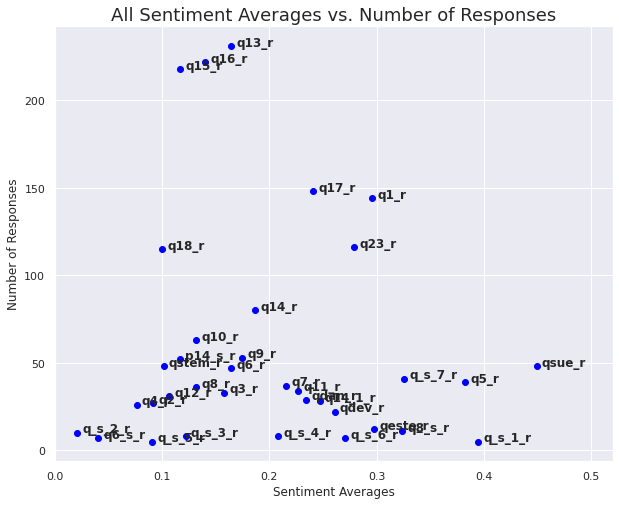

In [146]:
sns.set()
plt.rcParams['figure.figsize']=[10,8];

for name in avgs.columns:
 
  x=avgs[name][0]   #polarity values
  y=avgs[name][1]   #count of responses
  plt.scatter(x,y, color='blue');
  
  plt.text(x+.005, y+0.1, name, fontsize=12, fontweight='bold' ); # offset the name label
  
  # code to plot value with name
  # x_short=round(x,3)
  # y_short=round(y,3)
  # plt.text(x+0.005, y-0.006, (x_short,y_short), fontsize=10); # offset the name label
 
 # size plot frame
  plt.xlim(0, 0.52);

  plt.title('All Sentiment Averages vs. Number of Responses', fontsize=18);
  plt.xlabel('Sentiment Averages', fontsize=12);
  plt.ylabel('Number of Responses', fontsize=12);

###Averaging Response Sentiment over time by bootcamp

In [147]:
nlp1417.shape

(49, 43)

In [148]:
#rsadf_c = rsadf copy for year and bootcamp vectorization purposes.
rsadf_c = rsadf.copy()

In [149]:
rsadf_c['year'] = cdps['year'].copy()

In [150]:
rsadf_c['q1'] = cdps['q1'].copy()

In [151]:
rs1 = rsadf_c.copy()

In [152]:
rs1[rs1 == 'No Response'] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [153]:
rs1['p14_s_r'] = rs1['p14_s_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q10_r'] = rs1['q10_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q11_r'] = rs1['q11_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q12_r'] = rs1['q12_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q13_r'] = rs1['q13_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q14_r'] = rs1['q14_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q14_1_r'] = rs1['q14_1_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q15_r'] = rs1['q15_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q16_r'] = rs1['q16_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q17_r'] = rs1['q17_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q18_r'] = rs1['q18_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q1_r'] = rs1['q1_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q23_r'] = rs1['q23_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q2_r'] = rs1['q2_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q3_r'] = rs1['q3_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q4_r'] = rs1['q4_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q5_r'] = rs1['q5_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q6_r'] = rs1['q6_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q6_s_r'] = rs1['q6_s_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q7_r'] = rs1['q7_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q8_r'] = rs1['q8_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q8_s_r'] = rs1['q8_s_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q9_r'] = rs1['q9_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_1_r'] = rs1['q_s_1_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_2_r'] = rs1['q_s_2_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_3_r'] = rs1['q_s_3_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_4_r'] = rs1['q_s_4_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_5_r'] = rs1['q_s_5_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_6_r'] = rs1['q_s_6_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_7_r'] = rs1['q_s_7_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qdan_r'] = rs1['qdan_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qdev_r'] = rs1['qdev_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qeste_r'] = rs1['qeste_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qstem_r'] = rs1['qstem_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qsue_r'] = rs1['qsue_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')

In [154]:
rs1['year'] = rs1['year'].astype(int)

In [155]:
rs1 = rs1.rename(columns={'q1':'Bootcamp'})

In [156]:
#sa = Sentiment average by boot camp and year
sa = rs1.pivot_table(rs1, index=['Bootcamp', 'year'], aggfunc=np.nanmean, fill_value='-')

In [157]:
sa

p14_s_r        q10_r  ...    qstem_r    qsue_r
Bootcamp                  year                          ...                     
Data Science              2020          0         0.22  ...      -0.05      0.55
Digital Media             2018          -       0.2875  ...        0.1      0.45
                          2019 -0.0652778          0.1  ...   0.010625      0.65
                          2020   0.196429     0.189394  ...          -         -
Fullstack Web Development 2014          -         0.25  ...          -         -
                          2015          -     0.329167  ...          -         -
                          2016          -     0.369071  ...          -         -
                          2017          -     0.086067  ...       0.12         -
                          2018          -     0.181813  ...   0.219362  0.547292
                          2019  0.0785714     0.124797  ...   0.152274  0.489626
                          2020   0.143584    0.0603497  ... -0.0367674  0.416071
Internet of Things (IoT)  2020   0.209375    0.0325758  ...   0.129795  0.572222
Java+Android              2017          -     0.310714  ...          -         -
                          2018          -    0.0476587  ... -0.0496429  0.186429
                          2019   0.230648 -3.47222e-05  ...   0.418056  0.327972
                          2020  0.0231602   -0.0864583  ... -0.0333333     0.175
Microsoft .NET            2018          -            -  ...          -         -
                          2019          -            -  ...          -         -

[18 rows x 35 columns]

### Likert Scale responses over time

- begin with clean_data_post_likert
- convert likert to create pivot result

In [158]:
# dfpint = dataframe for pivot
dfpint=clean_data_post_likert

In [159]:
# replace index with Bootcamp column
dfpint=dfpint.rename(columns={'q1':'Bootcamp'})

In [160]:
# convert year to integer
dfpint['year'] = dfpint['year'].astype(int)

In [161]:
# convert each question so that pivot table function can operate on.
# note downcast to integer is ignored, it will make column float and
# any string found in column will be converted to 'NaN'
dfpint['q10'] = dfpint['q10'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q11'] = dfpint['q11'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q2'] = dfpint['q2'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q3'] = dfpint['q3'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q4'] = dfpint['q4'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q5'] = dfpint['q5'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q6'] = dfpint['q6'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q7'] = dfpint['q7'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q8'] = dfpint['q8'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q9'] = dfpint['q9'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qdan'] = dfpint['qdan'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qdev'] = dfpint['qdev'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qstem'] = dfpint['qstem'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qsue'] = dfpint['qsue'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')


Likert Pivot Table
Averages responses per Bootcamp/year and question.

In [162]:
pvt=dfpint.pivot_table(dfpint, index=['Bootcamp', 'year'], aggfunc=np.nanmean, fill_value='-')
pvt

q10       q11  ...    qstem     qsue
Bootcamp                  year                      ...                  
Data Science              2020  1.666667  1.666667  ...  1.66667        2
Digital Media             2018  1.166667  1.333333  ...  1.83333  1.83333
                          2019  0.750000  0.947368  ...     1.25      1.8
                          2020  1.000000  1.000000  ...  1.33333      1.5
Fullstack Web Development 2014  0.100000  0.500000  ...        -        -
                          2015  0.937500  0.937500  ...        -        -
                          2016  1.166667  1.416667  ...        -        -
                          2017  0.615385  1.153846  ...     1.25      1.6
                          2018  0.925000  1.300000  ...  1.41026    1.825
                          2019  0.977778  1.200000  ...  1.58696  1.78261
                          2020  0.687500  1.125000  ...        1  1.84375
Internet of Things (IoT)  2020  1.285714  1.714286  ...  1.57143        2
Java+Android              2017  1.500000  2.000000  ...        2      1.5
                          2018  1.107143  1.357143  ...  1.42857  1.64286
                          2019  1.281250  1.468750  ...  1.65625  1.70968
                          2020  1.250000  1.500000  ...  1.66667  1.83333
Microsoft .NET            2018  2.000000  2.000000  ...        2        1
                          2019  2.000000  2.000000  ...      1.5        1

[18 rows x 14 columns]



---



---



---



In [ ]:
b=rsadf_c.copy()
b[b == 'No Response'] = np.nan

In [211]:
b.head(2)

,p14_s_r,q10_r,q11_r,q12_r,q13_r,q14_1_r,q14_r,q15_r,q16_r,q17_r,q18_r,q1_r,q23_r,q2_r,q3_r,q4_r,q5_r,q6_r,q6_s_r,q7_r,q8_r,q8_s_r,q9_r,q_s_1_r,q_s_2_r,q_s_3_r,q_s_4_r,q_s_5_r,q_s_6_r,q_s_7_r,qdan_r,qdev_r,qeste_r,qstem_r,qsue_r,year,q1
0,NaN,0.511111,-0.05625,0.0625,0.319481,NaN,NaN,-0.166667,0.0814815,0.037037,0,0.26392,0.0128788,0.12,0.2,0,0.516667,-0.075,NaN,0.0354167,0.3125,NaN,0.478889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.269318,0.1,NaN,0.22,0.304762,2019.0,Fullstack Web Development
1,NaN,0.18,0.166667,NaN,0.5,NaN,NaN,0,0.43,0.32,NaN,0,NaN,NaN,NaN,NaN,0.65,0.5,NaN,0.2,0.0333333,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,Fullstack Web Development


In [165]:
import plotly.express as px
#b=rsadf_c[rsadf_c['q13_r']!='No Response'] 
fig=px.scatter(b, x='year', y='q13_r', color='q1')
fig.show()

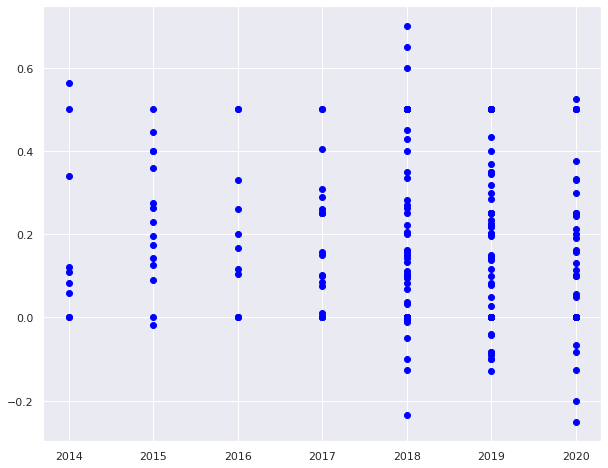

In [166]:

x=rsadf_c['year'][rsadf_c['q13_r']!='No Response']   #polarity values
y=rsadf_c['q13_r'][rsadf_c['q13_r']!= 'No Response'] #count of responses

plt.scatter(x,y, color='blue');

In [167]:
type(rsadf_c['year'][0])

numpy.float64

Take top 10 questions!!!

###Bootcamp Distribution

In [212]:
column_names_mapped['Which bootcamp did you attend?']

'q1'

In [213]:
#Bootcamp set
a=nlp1720['q1'].value_counts()
b=nlp19['q1'].value_counts()
c=nlp20['q1'].value_counts()

In [214]:
#Concatenate all three lists together
bootcamps=pd.concat([a, b, c], axis=1)

In [215]:
# Replace NAN and get total responses for each bootcamp
bootcamps=bootcamps.fillna(0)
bootcamps.loc[:,'Total']=bootcamps.sum(axis=1)

In [216]:
# Cleanup result
bootcamps_clean=bootcamps.drop(['q1'], axis=1, inplace=True)
bootcamps=bootcamps.drop(labels=['Response'], axis=0)

In [217]:
bootcamps

,Total
Fullstack Web Development,128.0
Java+Android,74.0
Digital Media,30.0
Microsoft .NET,3.0
Internet of Things (IoT),7.0
Data Science,3.0


##Data Proccessing

##Data Visualization

## 